# Deskripsi Project

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

# Langkah Pengerjaan Proyek
1. Muat datanya.
2. Lakukan pra-pemrosesan data apabila memang diperlukan.
3. Lakukan EDA dan buat kesimpulan terkait ketidakseimbangan kelas.
4. Lakukan pra-pemrosesan data untuk membuat model.
5. Latih setidaknya tiga model untuk train dataset yang ada.
6. Uji model untuk test dataset yang ada.
7. Tulis beberapa ulasanmu sendiri dan klasifikasikan dengan semua model.
8. Periksa perbedaan antara hasil pengujian model dari dua poin di atas. Coba untuk menjelaskan hasilnya.
9. Tampilkan hasil penemuanmu.

# Deskripsi Data
Data disimpan di file imdb_reviews.tsv. Unduh dataset.
Data ini diperoleh dari Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, dan Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Berikut adalah deskripsi untuk kolom yang dipilih:
- review: teks ulasan
- pos: target, '0' untuk negatif dan '1' untuk positif
- ds_part: 'train'/'test' untuk bagian train/test dari dataset

## Inisialisasi

In [ ]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [ ]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di
# https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Memuat data

In [ ]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [ ]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [ ]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

- **Dataframe df_reviews memiliki 47331 baris dan 17 kolom.**
- **Terdapat missing values pada kolom average_rating dan votes.**

In [ ]:
# Mengatasi missing values
df_reviews['average_rating'].fillna(np.nan, inplace=True)
df_reviews['votes'].fillna(np.nan, inplace=True)

In [ ]:
# Check apakah missing values sudah teratasi
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

## EDA

Periksa jumlah film dan ulasan selama beberapa tahun.

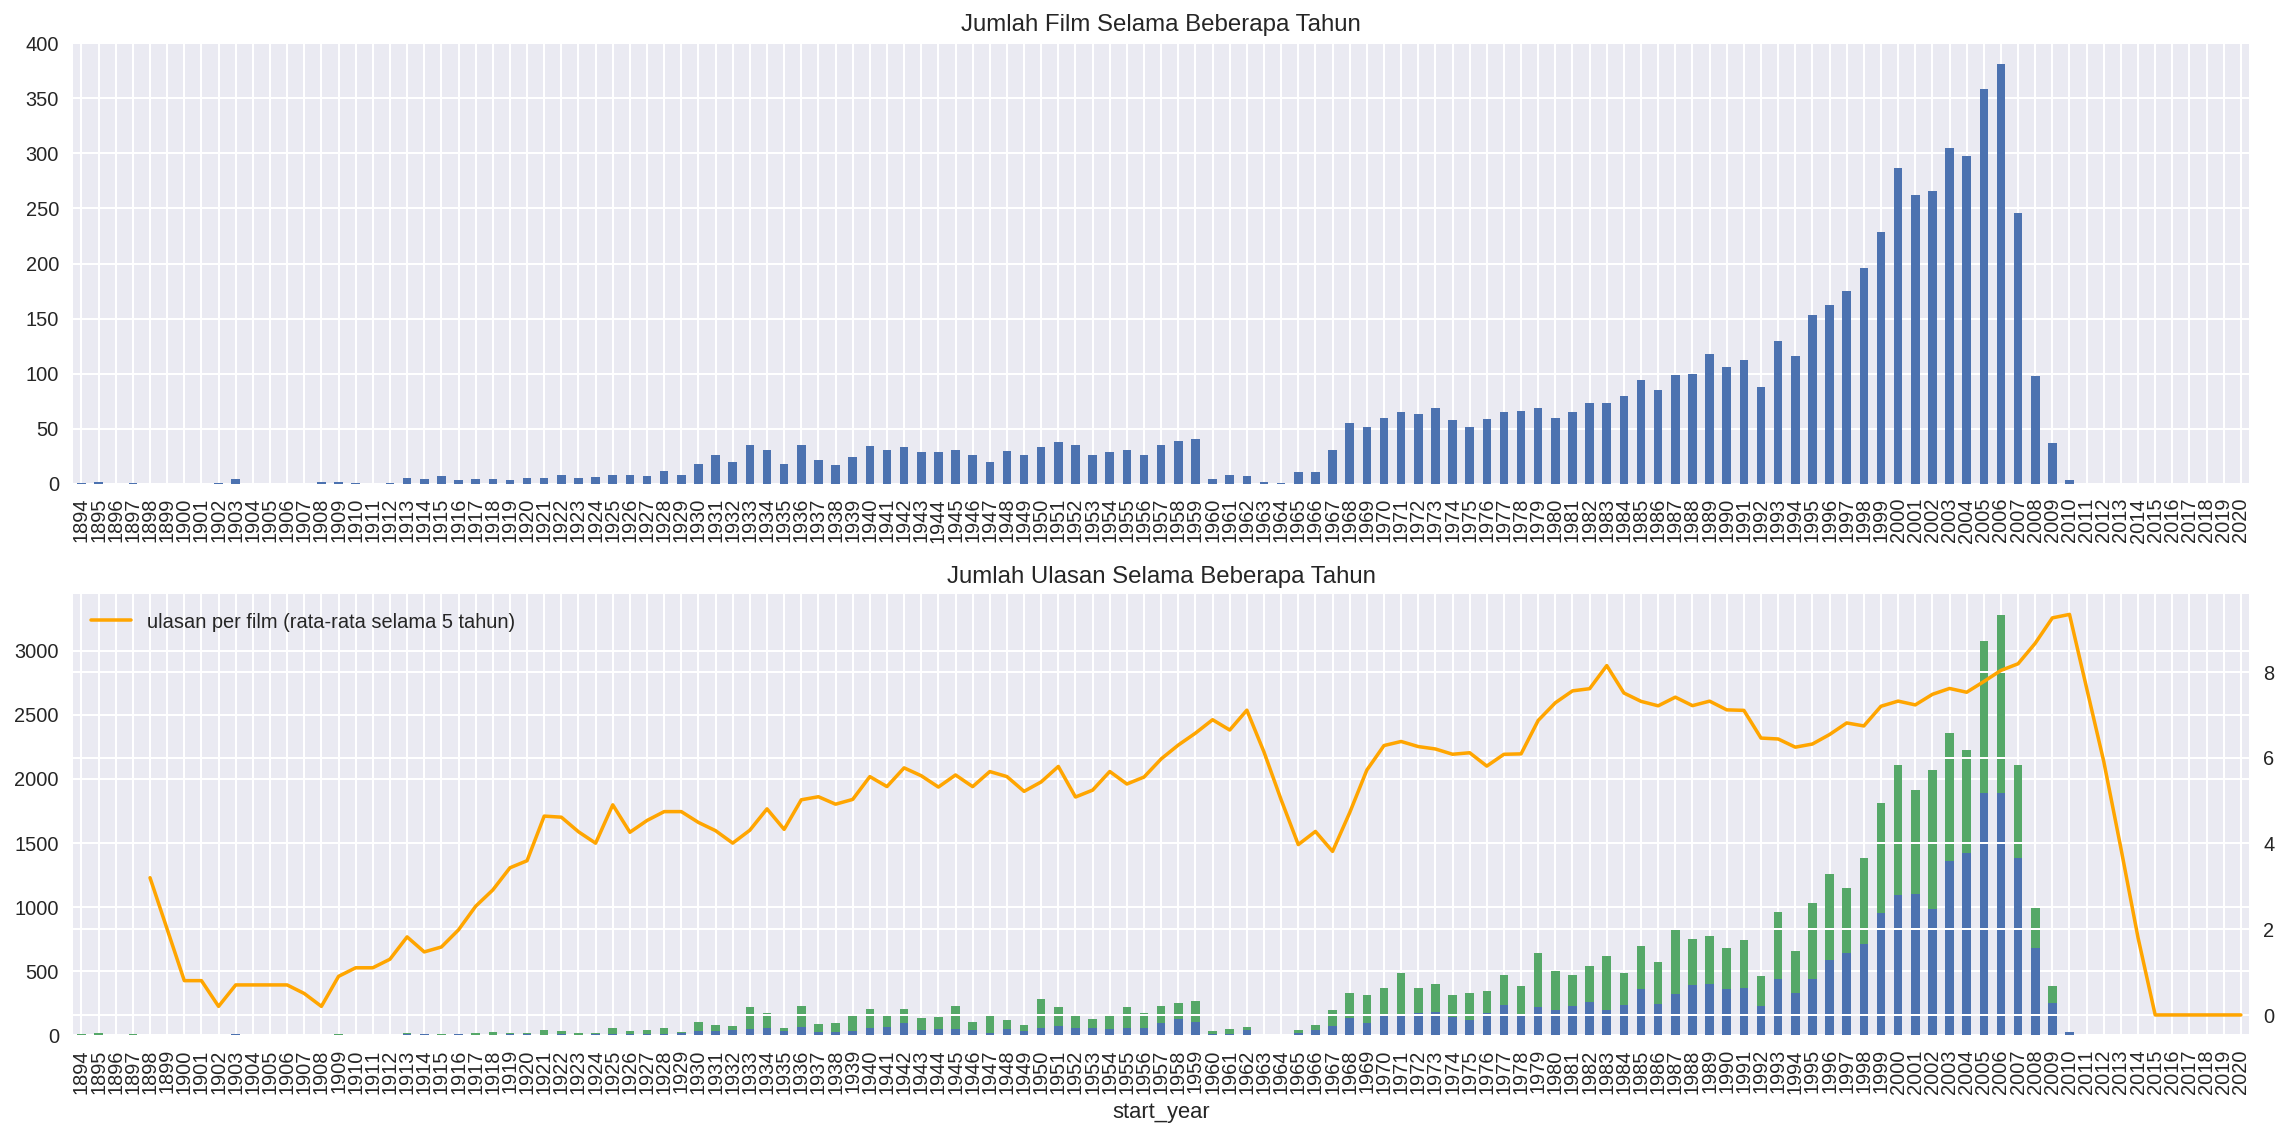

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Subplot 1: Jumlah Film Selama Beberapa Tahun
ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

# Subplot 2: Jumlah Ulasan Selama Beberapa Tahun
ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun')

fig.tight_layout()

**Bacaan Grafik:**
- Pada grafik diatas dapat dilihat bahwa jumlah film mengalami kenaikan dari tahun ke tahun dengan puncaknya berada pada tahun 2007, begitu juga dengan grafik ulasan filmnya meningkat seiring waktu, mencerminkan pertumbuhan industri film.

Periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

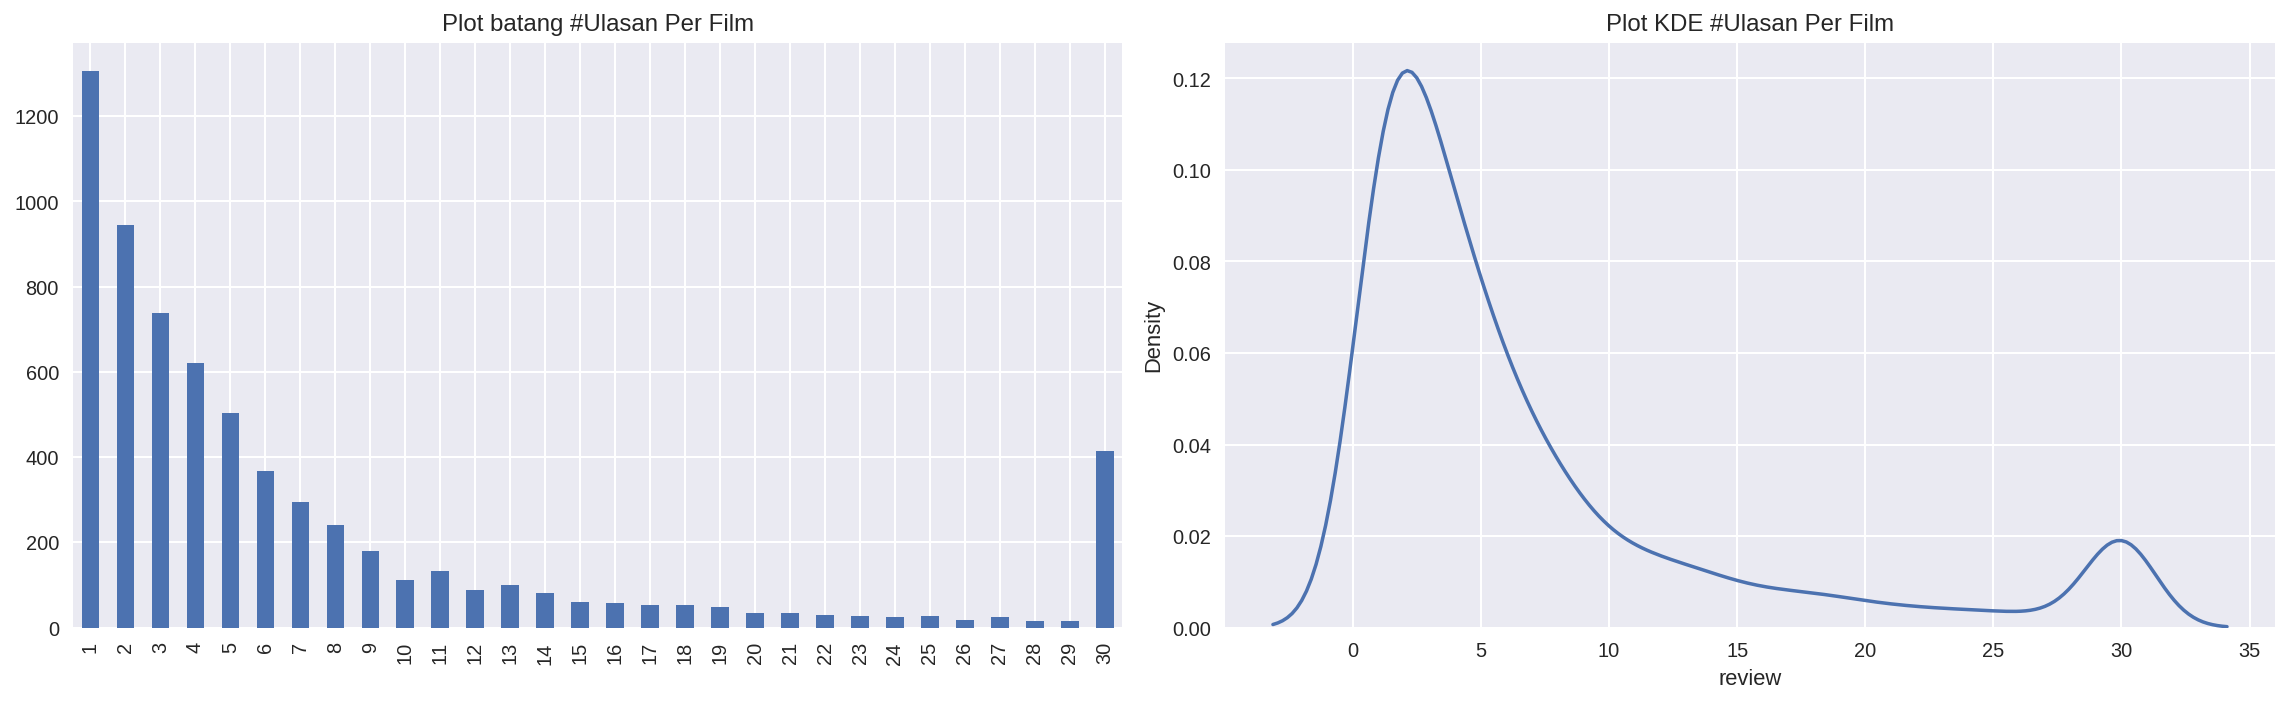

In [ ]:
# Distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film')

fig.tight_layout()

**Bacaan Grafik:**
- Pada grafik distribusi ulasan diatas dapat dilihat bahwa grafik dari puncak mengarah menurun, kita ambil dari 5 batang pertama dapat disimpulkan sebagian besar film dalam dataset mendapatkan jumlah ulasan antara 1 hingga 5. Setelah rentang ulasan 1-5 dan kemudian grafik terus menurus menurun.  

In [ ]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

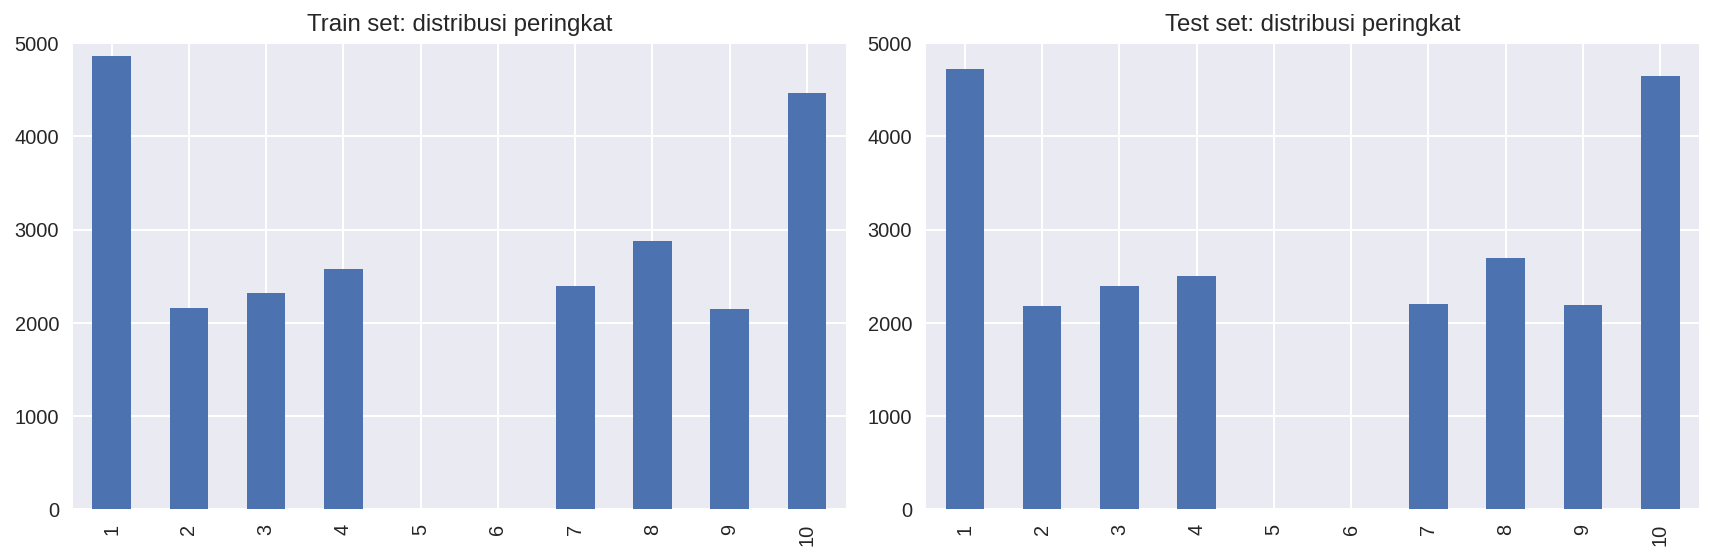

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribusi peringkat')

fig.tight_layout()

**Bacaan Grafik:**
- Pada diagram batang untuk distribusi peringkat pada train set dan Test set tampak serupa.

Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


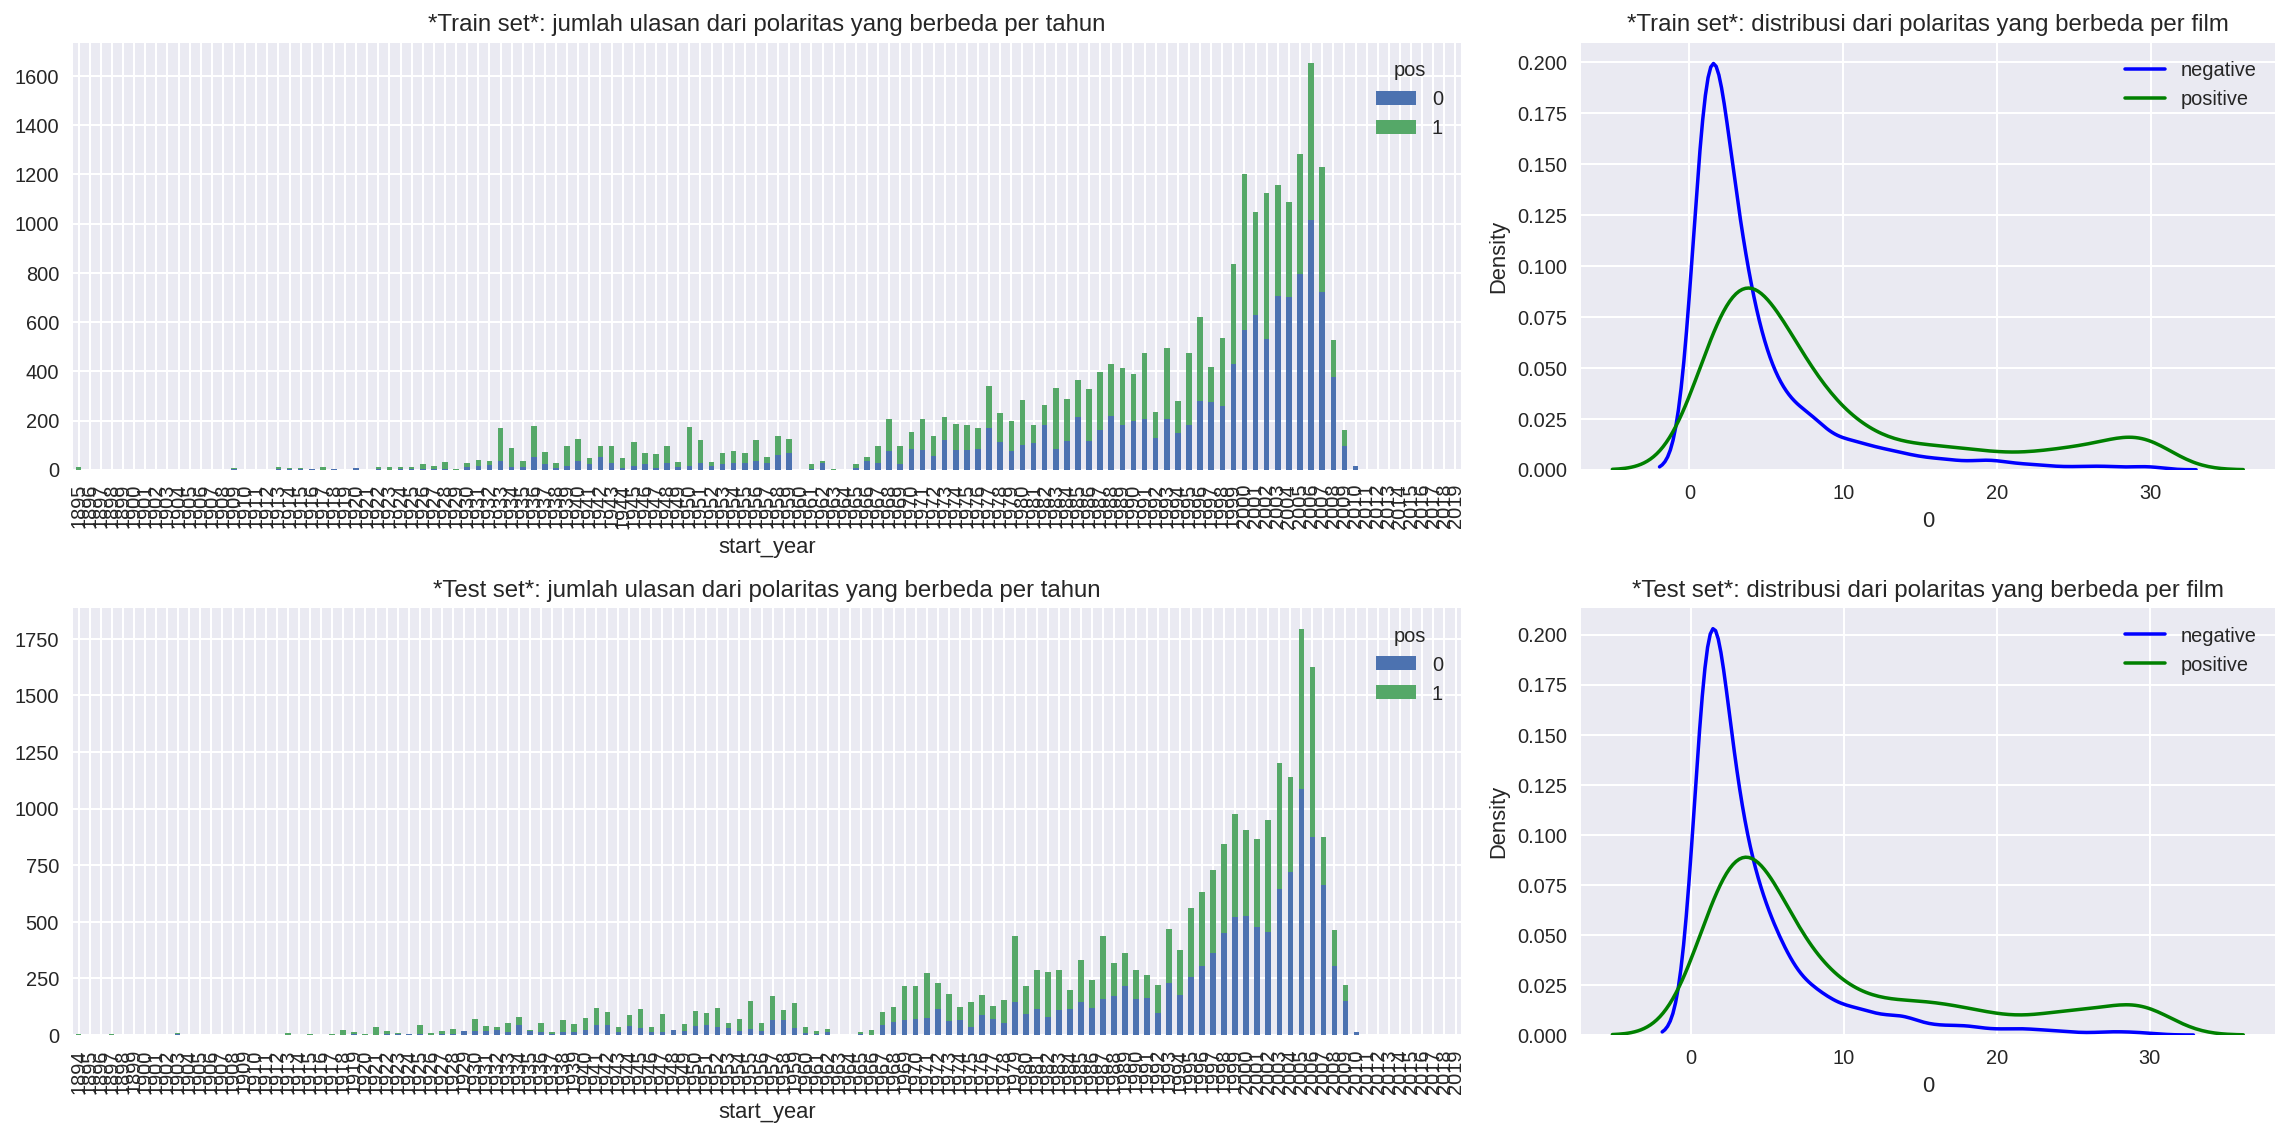

In [ ]:
# Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian dataset
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Plotting Train Set
ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Train set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')


# Plotting Test Set
ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Test set*: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

**Bacaan Grafik:**
- Pada grafik diatas dapat dilihat bahwa kedua grafik jumlah ulasan train set dan test tampak serupa berdasarkan jumlah ulasan negatif dan positif.

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [ ]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Kurva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

**Fungsi diatas bertujuan untuk mengevaluasi kinerja model klasifikasi pada dataset pelatihan (train set) dan dataset pengujian (test set). Dengan menggunakan metrik evaluasi seperti Akurasi, F1 Score, Area under the Precision-Recall Curve (APS), dan Area under the Receiver Operating Characteristic Curve (ROC AUC). Dan ada kesalahan pada penulisan 'Akurasi' (dengan bahasa Indonesia), sehingga diperbaiki menggunakan 'Accuracy'**

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [ ]:
# < masukkan kode di sini >
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: ''.join(ch.lower() for ch in x if ch.isalpha() or ch.isspace()))

In [ ]:
# Tampilkan beberapa baris pertama hasil normalisasi
print(df_reviews[['review', 'review_norm']].head())

                                              review  \
0  The pakage implies that Warren Beatty and Gold...   
1  How the hell did they get this made?! Presenti...   
2  There is no real story the film seems more lik...   
3  Um .... a serious film about troubled teens in...   
4  I'm totally agree with GarryJohal from Singapo...   

                                         review_norm  
0  the pakage implies that warren beatty and gold...  
1  how the hell did they get this made presenting...  
2  there is no real story the film seems more lik...  
3  um  a serious film about troubled teens in sin...  
4  im totally agree with garryjohal from singapor...  


**Deskripsi:**

Kode di atas melakukan normalisasi teks pada kolom 'review' dalam dataframe df_reviews. Normalisasi ini dilakukan dengan mengonversi semua karakter teks menjadi huruf kecil (lowercase) dan membuang karakter selain huruf dan spasi. Hasil normalisasi disimpan dalam kolom baru yang disebut 'review_norm'.

## Pemisahan Train / Test

Untungnya, seluruh *dataset* sudah dibagi menjadi *train/test*. Bendera yang sesuai adalah 'ds_part'.

In [ ]:
# Pemisahan Train / Test dari sampel
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


**Deskripsi:**
- Kode di atas melakukan pemisahan dataset menjadi dua bagian, yaitu train set dan test set, berdasarkan kolom 'ds_part' pada dataframe df_reviews. Train set dan test set disimpan dalam dua dataframe terpisah, yaitu df_reviews_train dan df_reviews_test. Selanjutnya, target (label) dari masing-masing set juga diambil dan disimpan dalam variabel train_target dan test_target.
- Train set (df_reviews_train) memiliki 23,796 baris dan 18 kolom.
- Test set (df_reviews_test) memiliki 23,535 baris dan 18 kolom.

## Bekerja dengan Model

### Model 1 - Konstan

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

In [ ]:
# Membuat model DummyClassifier
model_dummy = DummyClassifier(strategy="constant", constant=1)  # Menggunakan label positif (1)

In [ ]:
# Melatih model pada data pelatihan
model_dummy.fit(df_reviews_train[['average_rating']], train_target)

DummyClassifier(constant=1, strategy='constant')

In [ ]:
# Mengevaluasi model pada data pelatihan
print("Train Set:")
print(classification_report(train_target, model_dummy.predict(df_reviews_train[['average_rating']])))
print("===============================================")

Train Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11912
           1       0.50      1.00      0.67     11884

    accuracy                           0.50     23796
   macro avg       0.25      0.50      0.33     23796
weighted avg       0.25      0.50      0.33     23796



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Mengevaluasi model pada data uji
print("Test Set:")
print(classification_report(test_target, model_dummy.predict(df_reviews_test[['average_rating']])))

Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11803
           1       0.50      1.00      0.67     11732

    accuracy                           0.50     23535
   macro avg       0.25      0.50      0.33     23535
weighted avg       0.25      0.50      0.33     23535



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Deskripsi:**
- Kode di atas menciptakan dan mengevaluasi Model 1, yaitu Dummy Classifier dengan strategi konstan dan label positif (1). Model ini secara sederhana memprediksi semua sampel sebagai kelas positif tanpa memperhatikan fitur input.
- Pembuatan Model:
Membuat model Dummy Classifier dengan strategi konstan menggunakan label positif (1).
- Pelatihan Model:
Melatih model pada data pelatihan menggunakan fitur 'average_rating' dan target 'train_target'.
- Evaluasi Model pada Data Pelatihan:
Menampilkan classification report yang berisi metrik evaluasi seperti precision, recall, dan f1-score untuk model pada data pelatihan.
- Evaluasi Model pada Data Uji:
Menampilkan classification report yang berisi metrik evaluasi untuk model pada data uji.

**Temuan:**
- Data Pelatihan:
  - Akurasi model pada data pelatihan adalah 50%, yang sesuai dengan harapan karena model ini memprediksi seluruhnya sebagai kelas positif.
  - Precision dan recall untuk kelas positif (1) adalah 0.50 dan 1.00, sementara untuk kelas negatif (0) adalah 0.00 dan 0.00. Ini mencerminkan sifat model yang hanya memprediksi kelas positif.
  - F1-score untuk kelas positif adalah 0.67.

- Data Uji:
  - Hasil pada data uji serupa dengan data pelatihan.
  - Akurasi model pada data uji juga adalah 50%.
  - Precision dan recall untuk kelas positif (1) sama seperti pada data pelatihan, sementara untuk kelas negatif (0) adalah 0.00 dan 0.00.
  - F1-score untuk kelas positif adalah 0.67.

### Model 2 - NLTK, TF-IDF dan LR

TF-IDF

In [ ]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [ ]:
# Menggunakan stopwords dari NLTK
stop_words = set(stopwords.words('english'))

In [ ]:
# Membangun pipeline dengan TF-IDF dan model Logistic Regression
from sklearn.pipeline import Pipeline

model_tfidf_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('classifier', LogisticRegression())
])

In [ ]:
# Melatih model pada data pelatihan
model_tfidf_lr.fit(df_reviews_train['review_norm'], train_target)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('classifier', LogisticRegression())])

In [ ]:
# Mengevaluasi model pada data pelatihan
print("Train Set:")
train_predictions = model_tfidf_lr.predict(df_reviews_train['review_norm'])
print(classification_report(train_target, train_predictions))
print("===============================================")

Train Set:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     11912
           1       0.93      0.95      0.94     11884

    accuracy                           0.94     23796
   macro avg       0.94      0.94      0.94     23796
weighted avg       0.94      0.94      0.94     23796



In [ ]:
# Mengevaluasi model pada data uji
print("Test Set:")
test_predictions = model_tfidf_lr.predict(df_reviews_test['review_norm'])
print(classification_report(test_target, test_predictions))

Test Set:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     11803
           1       0.88      0.88      0.88     11732

    accuracy                           0.88     23535
   macro avg       0.88      0.88      0.88     23535
weighted avg       0.88      0.88      0.88     23535



          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


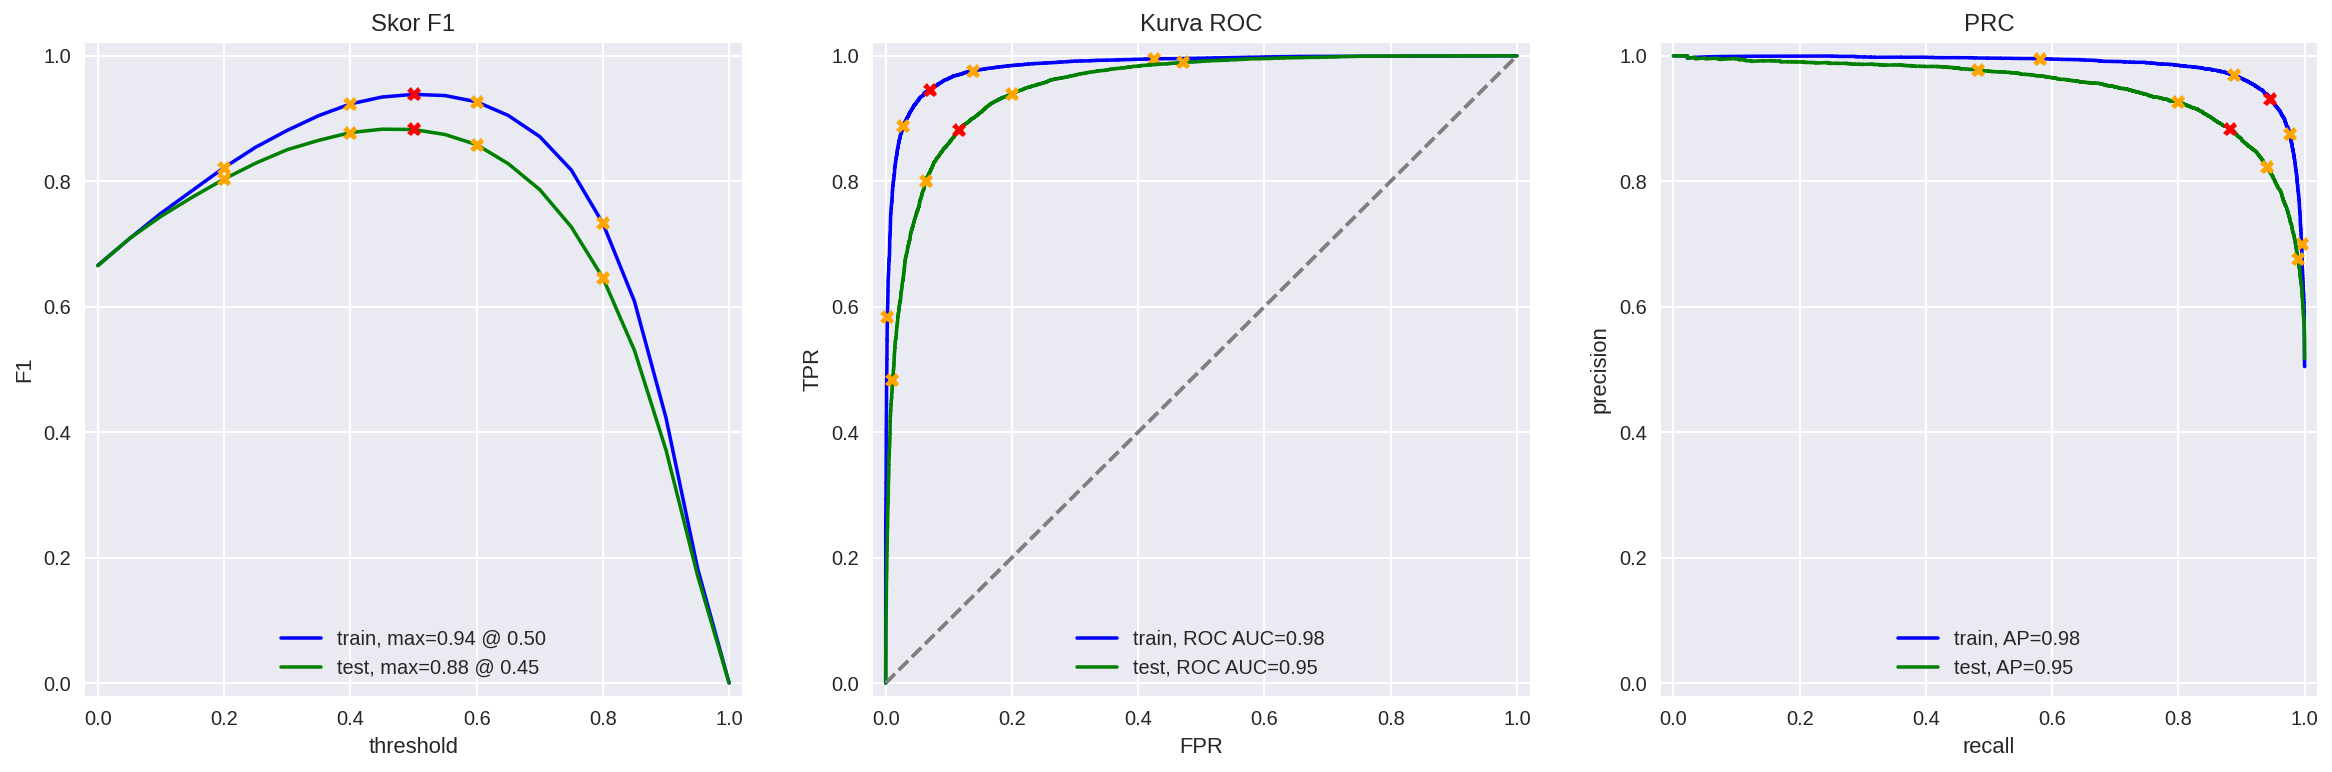

In [ ]:
# Evaluasi Model 2
evaluate_model(model_tfidf_lr, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)


**Deskripsi:**
- Kode di atas membuat dan mengevaluasi Model 2, yaitu menggunakan TF-IDF (Term Frequency-Inverse Document Frequency) sebagai fitur dan model Logistic Regression untuk klasifikasi ulasan film.
- Pembuatan Model:
Membangun pipeline dengan TF-IDF dan model Logistic Regression.
Melatih model pada data pelatihan menggunakan teks yang telah dinormalisasi ('review_norm') dan target 'train_target'.
- Evaluasi Model pada Data Pelatihan:
Menampilkan classification report yang berisi metrik evaluasi seperti precision, recall, dan f1-score untuk model pada data pelatihan.
- Evaluasi Model pada Data Uji:
Menampilkan classification report yang berisi metrik evaluasi untuk model pada data uji.
- Evaluasi Model secara Keseluruhan:
Menggunakan fungsi evaluate_model untuk mengevaluasi model pada kedua set (pelatihan dan uji).
Menampilkan akurasi, F1-score, APS (Average Precision Score), dan ROC AUC (Area Under the Receiver Operating Characteristic Curve) untuk kedua set.

**Temuan:**
- Data Pelatihan:
  - Akurasi model pada data pelatihan adalah 94%, menunjukkan kinerja yang sangat baik.
  - Precision, recall, dan f1-score untuk kedua kelas (0 dan 1) juga sangat tinggi, mencapai nilai di atas 0.93.

- Data Uji:
  - Model memiliki kinerja yang baik pada data uji dengan akurasi sekitar 88%.
  - Precision, recall, dan f1-score untuk kedua kelas (0 dan 1) tetap tinggi, menunjukkan kemampuan model untuk memprediksi kelas dengan baik.


### Model 3 - spaCy, TF-IDF dan LR

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import spacy

# Load model spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
# Fungsi untuk normalisasi teks menggunakan spaCy
def text_preprocessing_3(text):
    if isinstance(text, str):  # Memastikan teks adalah string
        doc = nlp(text)
        tokens = [str(token.lemma_).lower() if isinstance(token.lemma_, str) else str(token.lemma_) for token in doc]
        return tokens  # Mengembalikan list of strings
    else:
        return []  # Jika bukan string, kembalikan list kosong

In [ ]:
# Inisialisasi vektorizer
tfidf_vectorizer_3 = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x)

In [ ]:
# Melatih vektorizer dan model klasifikasi dengan data latihan
df_reviews_train_3 = df_reviews[df_reviews['ds_part'] == "train"].copy()
df_reviews_test_3 = df_reviews[df_reviews['ds_part'] == "test"].copy()

In [ ]:
# Normalisasi teks menggunakan fungsi text_preprocessing_3
df_reviews_train_3['review_norm_3'] = df_reviews_train_3['review'].apply(text_preprocessing_3)
df_reviews_test_3['review_norm_3'] = df_reviews_test_3['review'].apply(text_preprocessing_3)

In [ ]:
# Melatih vektorizer dengan data latihan Model 3
tfidf_vectorizer_3.fit(df_reviews_train_3['review_norm_3'])

/opt/conda/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


TfidfVectorizer(preprocessor=<function <lambda> at 0x7f2897234e50>,
                tokenizer=<function <lambda> at 0x7f2897234d30>)

In [ ]:
# Menggunakan vektorizer untuk transformasi data latihan dan uji
train_features_3 = tfidf_vectorizer_3.transform(df_reviews_train_3['review_norm_3'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test_3['review_norm_3'])

In [ ]:
# Modifikasi pipeline
model_tfidf_lr = Pipeline([
    ('classifier', LogisticRegression())
])

In [ ]:
# Melatih model klasifikasi
model_tfidf_lr.fit(train_features_3, df_reviews_train_3['pos'])

Pipeline(steps=[('classifier', LogisticRegression())])

In [ ]:
# Mengevaluasi model pada data pelatihan
train_predictions_3 = model_tfidf_lr.predict(train_features_3)
accuracy_train_3 = accuracy_score(df_reviews_train_3['pos'], train_predictions_3)
classification_rep_train_3 = classification_report(df_reviews_train_3['pos'], train_predictions_3)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Melakukan prediksi pada data uji
predictions_3 = model_tfidf_lr.predict(test_features_3)

In [ ]:
# Mengevaluasi kinerja model
accuracy_3 = accuracy_score(df_reviews_test_3['pos'], predictions_3)
classification_rep_3 = classification_report(df_reviews_test_3['pos'], predictions_3)

In [ ]:
# Menampilkan hasil evaluasi pada data pelatihan
print(f'Train Set Accuracy: {accuracy_train_3:.4f}')
print('Train Set Classification Report:')
print(classification_rep_train_3)

Train Set Accuracy: 0.9264
Train Set Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     11912
           1       0.92      0.93      0.93     11884

    accuracy                           0.93     23796
   macro avg       0.93      0.93      0.93     23796
weighted avg       0.93      0.93      0.93     23796



In [ ]:
# Menampilkan hasil evaluasi
print(f'Accuracy: {accuracy_3:.4f}')
print('Classification Report:')
print(classification_rep_3)

Accuracy: 0.8829
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     11803
           1       0.88      0.89      0.88     11732

    accuracy                           0.88     23535
   macro avg       0.88      0.88      0.88     23535
weighted avg       0.88      0.88      0.88     23535



**Deskripsi:**
- Kode di atas membuat dan mengevaluasi Model 3, yang menggunakan spaCy untuk normalisasi teks, TF-IDF sebagai fitur, dan model Logistic Regression untuk klasifikasi ulasan film.
- Pembuatan Model:
  - Menggunakan spaCy untuk normalisasi teks dengan lemma sebagai token.
  - Menggunakan TF-IDF Vectorizer untuk mengubah teks menjadi fitur TF-IDF.
  - Menggunakan model Logistic Regression untuk klasifikasi.
-Evaluasi Model pada Data Uji:
  - Melakukan prediksi pada data uji.
  - Mengevaluasi kinerja model dengan menghitung akurasi dan menampilkan classification report yang berisi metrik evaluasi seperti precision, recall, dan f1-score.
  
**Temuan:**
- Data Pelatihan:
  - Akurasi Model 3 pada data pelatihan mencapai 92.64%, menunjukkan performa yang sangat baik.
  - Precision, recall, dan f1-score untuk kelas 0 (negatif) dan 1 (positif) sangat tinggi, dengan nilai di atas 0.92.
  
- Data Uji:
  - Model ini memiliki akurasi sekitar 88%, menunjukkan kinerja yang baik pada data uji.
  - Precision, recall, dan f1-score untuk kedua kelas (0 dan 1) sangat baik, mencapai nilai di atas 0.88.

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Load model spaCy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Fungsi untuk normalisasi teks menggunakan spaCy
def text_preprocessing_3(text):
    if isinstance(text, str):  # Memastikan teks adalah string
        doc = nlp(text)
        tokens = [str(token.lemma_).lower() if isinstance(token.lemma_, str) else str(token.lemma_) for token in doc]
        return ' '.join(tokens)  # Menggabungkan list of strings menjadi satu string
    else:
        return ''  # Jika bukan string, kembalikan string kosong

In [ ]:
# Normalisasi teks menggunakan fungsi text_preprocessing_3
df_reviews['review_norm_4'] = df_reviews['review'].apply(text_preprocessing_3)

In [ ]:
# Pemisahan Train/Test
df_reviews_train_4 = df_reviews.query('ds_part == "train"').copy()
df_reviews_test_4 = df_reviews.query('ds_part == "test"').copy()

train_target_4 = df_reviews_train_4['pos']
test_target_4 = df_reviews_test_4['pos']

In [ ]:
# Inisialisasi dan melatih model TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
train_features_4 = tfidf_vectorizer.fit_transform(df_reviews_train_4['review_norm_4'])

In [ ]:
# Inisialisasi dan melatih model LGBMClassifier
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(tfidf_vectorizer.transform(df_reviews_train_4['review_norm_4']), train_target_4)

LGBMClassifier(random_state=42)

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


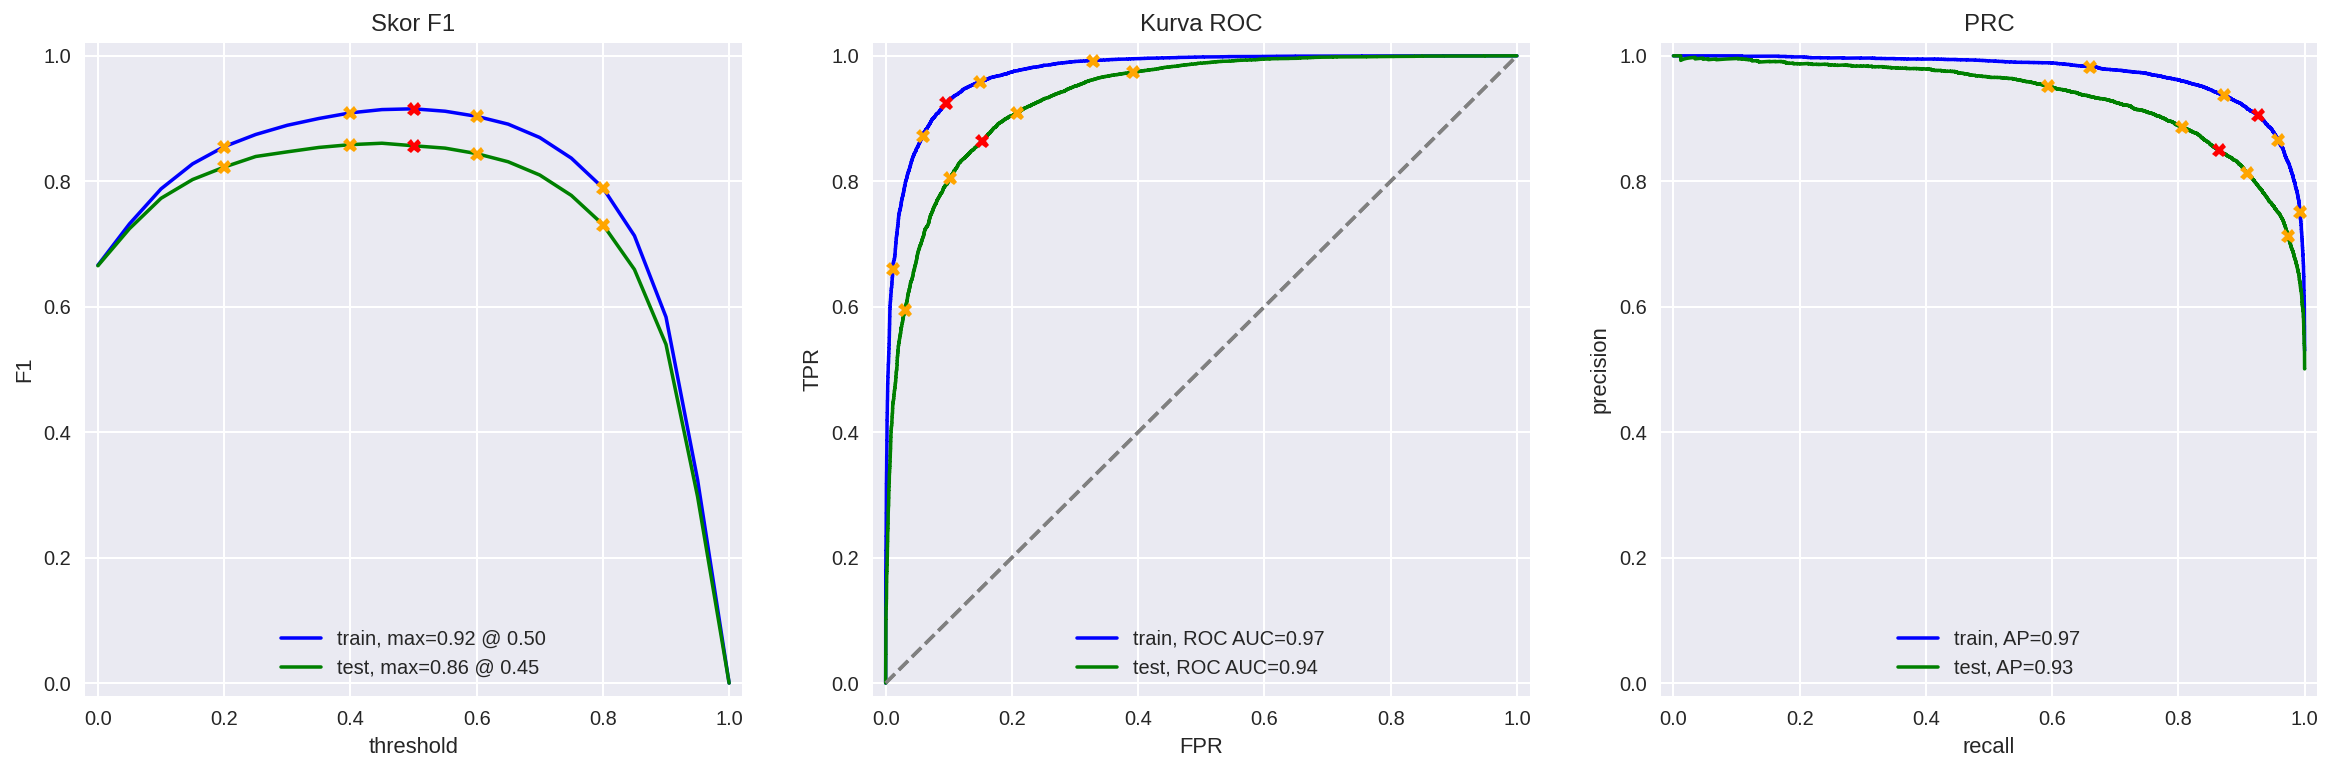

In [ ]:
# Evaluasi Model 4
evaluate_model(model_lgbm, tfidf_vectorizer.transform(df_reviews_train_4['review_norm_4']), train_target_4,
               tfidf_vectorizer.transform(df_reviews_test_4['review_norm_4']), test_target_4)

**Deskripsi:**
- Model 4 menggunakan kombinasi spaCy untuk normalisasi teks, TF-IDF (Term Frequency-Inverse Document Frequency) untuk ekstraksi fitur, dan LGBMClassifier sebagai model klasifikasi.
- Teks direpresentasikan dalam bentuk vektor TF-IDF, yang kemudian digunakan untuk melatih model LGBMClassifier.

**Temuan:**
- Data Pelatihan:
  - Model 4 (LGBMClassifier) memiliki akurasi sekitar 91% pada data pelatihan, menunjukkan kinerja yang baik.
  - F1-score yang tinggi (0.92) menunjukkan kemampuan model dalam memprediksi dengan baik untuk kedua kelas (0 dan 1).
  - APS (Average Precision Score) dan ROC AUC Score mencapai nilai yang sangat tinggi, yaitu 0.97, menunjukkan keunggulan model dalam memisahkan kelas positif dan negatif.

- Data Uji:
  - Model 4 memiliki akurasi sekitar 86% pada data uji, menunjukkan performa yang baik tetapi sedikit lebih rendah dibandingkan dengan data pelatihan.
  - F1-score tetap tinggi (0.86), menunjukkan kemampuan model untuk mempertahankan keseimbangan presisi dan recall pada kedua kelas.
  - APS dan ROC AUC Score pada data uji juga tetap tinggi, menunjukkan konsistensi dalam kinerja model.

## Ulasan Saya

In [ ]:
# jangan ragu untuk menghapus ulasan ini dan mencoba modelmu sendiri terhadap ulasanmu, ini hanya sekadar contoh saja
my_reviews = pd.DataFrame([
    'I did not really like it; it is not my favorite type of movie.',
    'Boring, I even fell asleep in the middle of the film.',
    'The movie is really good; I enjoyed it a lot.',
    'Even the actors looked very old and uninterested in the movie. Are they paid to act in this? Truly disappointing.',
    'I did not expect the movie to be this good! The writers really paid attention to every detail.',
    'This film has its strengths and weaknesses, but overall, I think it is a worthwhile movie. I might watch it again.',
    'Some of the jokes are really not funny. Not a single joke landed; everyone acted annoying, even kids would not like this!',
    'Airing this movie on Netflix is a bold move, and Iam very happy to watch episode after episode of this exciting and intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(text_preprocessing_3) # <masukkan logika normalisasi yang sama di sini sebagaimana pada dataset utama>

my_reviews

,review,review_norm
0,I did not really like it; it is not my favorit...,i do not really like it ; it be not my favorit...
1,"Boring, I even fell asleep in the middle of th...","boring , i even fall asleep in the middle of t..."
2,The movie is really good; I enjoyed it a lot.,the movie be really good ; i enjoy it a lot .
3,Even the actors looked very old and uninterest...,even the actor look very old and uninterested ...
4,I did not expect the movie to be this good! Th...,i do not expect the movie to be this good ! th...
5,"This film has its strengths and weaknesses, bu...","this film have its strength and weakness , but..."
6,Some of the jokes are really not funny. Not a ...,some of the joke be really not funny . not a s...
7,"Airing this movie on Netflix is a bold move, a...","air this movie on netflix be a bold move , and..."


### Model 1

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_dummy.predict_proba(df_reviews_test[['average_rating']])[:, 1]

# Tampilkan hasil prediksi untuk 100 ulasan pertama
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

1.00:  i do not really like it ; it be not my favorite type of movie .
1.00:  boring , i even fall asleep in the middle of the film .
1.00:  the movie be really good ; i enjoy it a lot .
1.00:  even the actor look very old and uninterested in the movie . be they pay to act in this ? truly disa
1.00:  i do not expect the movie to be this good ! the writer really pay attention to every detail .
1.00:  this film have its strength and weakness , but overall , i think it be a worthwhile movie . i might 
1.00:  some of the joke be really not funny . not a single joke land ; everyone act annoying , even kid wou
1.00:  air this movie on netflix be a bold move , and iam very happy to watch episode after episode of this


Prediksi Probability Seragam: Model Dummy memberikan prediksi probabilitas yang seragam pada dataset ulasan yang diberikan. Semua prediksi memiliki nilai 1.00, yang menunjukkan bahwa model Dummy tidak memberikan perbedaan signifikan antar ulasan.

### Model 3

In [ ]:
texts = my_reviews['review_norm'].apply(text_preprocessing_3)
my_reviews_pred_prob = model_tfidf_lr.predict_proba(tfidf_vectorizer_3.transform(texts))[:, 1]

# Tampilkan hasil prediksi untuk 100 ulasan pertama
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}: {review}')

0.41: i do not really like it ; it be not my favorite type of movie .
0.44: boring , i even fall asleep in the middle of the film .
0.45: the movie be really good ; i enjoy it a lot .
0.40: even the actor look very old and uninterested in the movie . be they pay to act in this ? truly disa
0.44: i do not expect the movie to be this good ! the writer really pay attention to every detail .
0.41: this film have its strength and weakness , but overall , i think it be a worthwhile movie . i might 
0.41: some of the joke be really not funny . not a single joke land ; everyone act annoying , even kid wou
0.43: air this movie on netflix be a bold move , and iam very happy to watch episode after episode of this


Prediksi Probability dengan Model TF-IDF dan Logistic Regression: Model TF-IDF dengan Logistic Regression memberikan variasi dalam prediksi probabilitas pada dataset ulasan yang diberikan. Nilai probabilitas berkisar antara 0.40 hingga 0.45.

### Model 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer
my_reviews_pred_prob = model_lgbm.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.85:  i do not really like it ; it be not my favorite type of movie .
0.13:  boring , i even fall asleep in the middle of the film .
0.88:  the movie be really good ; i enjoy it a lot .
0.16:  even the actor look very old and uninterested in the movie . be they pay to act in this ? truly disa
0.76:  i do not expect the movie to be this good ! the writer really pay attention to every detail .
0.59:  this film have its strength and weakness , but overall , i think it be a worthwhile movie . i might 
0.22:  some of the joke be really not funny . not a single joke land ; everyone act annoying , even kid wou
0.73:  air this movie on netflix be a bold move , and iam very happy to watch episode after episode of this


Prediksi Probability dengan Model TF-IDF dan LGBMClassifier: Model LGBMClassifier dengan TF-IDF memberikan prediksi probabilitas yang beragam pada dataset ulasan yang diberikan. Nilai probabilitas berkisar dari 0.13 hingga 0.88.

## Kesimpulan

- Dataframe df_reviews memiliki 47331 baris dan 17 kolom.
- Terdapat missing values pada kolom average_rating dan votes. Dan saat ini missing values sudah ditangani.
- Pemisahan Data: Data telah dibagi menjadi dua bagian: train dan test menggunakan kolom 'ds_part'.
- Model 1 - Konstan:
  - Menggunakan DummyClassifier dengan prediksi konstan.
  - Data Pelatihan:
    - Akurasi model pada data pelatihan adalah 50%, yang sesuai dengan harapan karena model ini memprediksi seluruhnya sebagai kelas positif.
    - Precision dan recall untuk kelas positif (1) adalah 0.50 dan 1.00, sementara untuk kelas negatif (0) adalah 0.00 dan 0.00. Ini mencerminkan sifat model yang hanya memprediksi kelas positif.
    - F1-score untuk kelas positif adalah 0.67.

  - Data Uji:
    - Hasil pada data uji serupa dengan data pelatihan.
    - Akurasi model pada data uji juga adalah 50%.
    - Precision dan recall untuk kelas positif (1) sama seperti pada data pelatihan, sementara untuk kelas negatif (0) adalah 0.00 dan 0.00.
    - F1-score untuk kelas positif adalah 0.67.
    
- Model 2 - NLTK, TF-IDF, LR:
  - Menggunakan TfidfVectorizer dari NLTK untuk vektorisasi.
  - Model Logistic Regression.
  - Data Pelatihan:
    - Akurasi model pada data pelatihan adalah 94%, menunjukkan kinerja yang sangat baik.
    - Precision, recall, dan f1-score untuk kedua kelas (0 dan 1) juga sangat tinggi, mencapai nilai di atas 0.93.

  - Data Uji:
    - Model memiliki kinerja yang baik pada data uji dengan akurasi sekitar 88%.
    - Precision, recall, dan f1-score untuk kedua kelas (0 dan 1) tetap tinggi dinilai 0.8, menunjukkan kemampuan model untuk memprediksi kelas dengan baik.
  
- Model 3 - spaCy, TF-IDF, LR:
  - Normalisasi teks dengan spaCy.
  - Menggunakan TfidfVectorizer untuk vektorisasi.
  - Model Logistic Regression.
  - Data Pelatihan:
   - Akurasi Model 3 pada data pelatihan mencapai 92.64%, menunjukkan performa yang sangat baik.
   - Precision, recall, dan f1-score untuk kelas 0 (negatif) dan 1 (positif) sangat tinggi, dengan nilai di atas 0.92.

- Data Uji:
  - Model ini memiliki akurasi sekitar 88%, menunjukkan kinerja yang baik pada data uji.
  - Precision, recall, dan f1-score untuk kedua kelas (0 dan 1) sangat baik, mencapai nilai di atas 0.88.
  
  
- Model 4 - spaCy, TF-IDF, LGBMClassifier:
  - Normalisasi teks dengan spaCy.
  - Menggunakan TfidfVectorizer.
  - Model LGBMClassifier.
  - Data Pelatihan:
    - Model 4 (LGBMClassifier) memiliki akurasi sekitar 91% pada data pelatihan, menunjukkan kinerja yang baik.
    - F1-score yang tinggi (0.92) menunjukkan kemampuan model dalam memprediksi dengan baik untuk kedua kelas (0 dan 1).
    - APS (Average Precision Score) dan ROC AUC Score mencapai nilai yang sangat tinggi, yaitu 0.97, menunjukkan keunggulan model dalam memisahkan kelas positif dan negatif.

  - Data Uji:
    - Model 4 memiliki akurasi sekitar 86% pada data uji, menunjukkan performa yang baik tetapi sedikit lebih rendah dibandingkan dengan data pelatihan.
    - F1-score tetap tinggi (0.86), menunjukkan kemampuan model untuk mempertahankan keseimbangan presisi dan recall pada kedua kelas.
    - APS dan ROC AUC Score pada data uji juga tetap tinggi, menunjukkan konsistensi dalam kinerja model.